In [1]:
import re, random, math, os
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, f1_score


In [2]:
# -----------------
# Cargar el Dataset
# -----------------

ruta_excel = 'Abstracts.xlsx'

try:
    # Cargar la hoja de ABSTRACTS
    df_abstracts = pd.read_excel(ruta_excel, sheet_name='ABSTRACTS')

    # Cargar la hoja de EVALUATIONS
    df_evaluations = pd.read_excel(ruta_excel, sheet_name='EVALUATIONS')

    print("Dataset cargado correctamente.")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta '{ruta_excel}'.")
except Exception as e:
    # Este 'except' es para otros errores, como que los nombres de las hojas no sean correctos.
    print(f"Ocurrió un error al leer el archivo Excel: {e}")


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Dataset cargado correctamente.


In [3]:
# ------------------------
# Exploración de los datos
# ------------------------

# Explorando Abstracts
print("---------------------------")
print("Información de df_abstracts")
print("---------------------------")
print("\nForma del DataFrame (filas, columnas)")
print(df_abstracts.shape)

print("\nPrimeras 5 filas")
display(df_abstracts.head())

print("\nInformación general y tipos de datos\n")
df_abstracts.info()

print("\n" + "="*80 + "\n")

# Explorando Evaluaciones
print("-----------------------------")
print("Información de df_evaluations")
print("-----------------------------")
print("\nForma del DataFrame (filas, columnas)")
print(df_evaluations.shape)

print("\nPrimeras 5 filas")
display(df_evaluations.head())

print("\nInformación general y tipos de datos\n")
df_evaluations.info()

---------------------------
Información de df_abstracts
---------------------------

Forma del DataFrame (filas, columnas)
(3789, 13)

Primeras 5 filas


,Abstract_Id,Numero_Nuevo,Title,Authors,Body,Topic_1,Topic_2,Topic_3,Topic_Final,Presentacion_Final,Average,StdDev,Evaluations
0,375,105.0,CUTANEOUS MALAKOPLAKIA. A CASE WITH THREE DIFF...,G Jimenez-Diaz,A 16 year old girl with unremarkable medical h...,14 - Infections – bacteriology,13 - Immunology,NaN,14 - Infections – bacteriology,Clinical Case (ORAL),6.0,0.0,1
1,1508,106.0,DISSEMINATED ECTHYMA GANGRENOSUM IN INFANTS AN...,"JF Dayrit, GB Teodosio",PURPOSE OF THE STUDY\nTo demonstrate the clini...,14 - Infections – bacteriology,25 - Pediatric and neonatal dermatology,NaN,14 - Infections – bacteriology,Clinical Case (ORAL),4.0,0.0,1
2,1686,107.0,HAND NEUROPATHY: A CORRELATION OF CLINICAL AND...,"JL Chua, CD Villarama-Cellona, FC Roa",RESEARCH QUESTION: Can the Semmes-Weinstein (S...,14 - Infections – bacteriology,NaN,NaN,14 - Infections – bacteriology,Clinical Case (ORAL),5.0,0.0,1
3,2227,108.0,PAPULONECROTIC TUBERCULIDS: SERIES OF 18 PATIE...,"K Sandhu, B Kumar",Background:Tuberculids are a heterogenous grou...,14 - Infections – bacteriology,NaN,NaN,14 - Infections – bacteriology,Clinical Case (ORAL),5.0,0.0,1
4,2477,109.0,CUTANEOUS MULTI-DRUG RESISTANT TUBERCULOSIS IN...,"AU Surjushe, SR Jindal, S Medhekar, DG Saple",Background: Multi-drug resistant tuberculosis ...,14 - Infections – bacteriology,NaN,NaN,14 - Infections – bacteriology,Clinical Case (ORAL),5.0,0.0,1



Información general y tipos de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3789 entries, 0 to 3788
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Abstract_Id         3789 non-null   int64  
 1   Numero_Nuevo        3779 non-null   float64
 2   Title               3789 non-null   object 
 3   Authors             3789 non-null   object 
 4   Body                3775 non-null   object 
 5   Topic_1             3789 non-null   object 
 6   Topic_2             1475 non-null   object 
 7   Topic_3             549 non-null    object 
 8   Topic_Final         3789 non-null   object 
 9   Presentacion_Final  3789 non-null   object 
 10  Average             3789 non-null   float64
 11  StdDev              3789 non-null   float64
 12  Evaluations         3789 non-null   int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 384.9+ KB


-----------------------------
Información de df_evalu

,Abstract_Id,Reviewer_Last_Name,Reviewer_First_Name,Score,Comments,Suggested_Edit,Incomprehensible
0,2,Casas,Gabriel,3,NaN,False,False
1,2,Stengel,Fernando M.,4,good clinical single case,False,False
2,3,Stengel,Fernando M.,5,Two case presentation,False,False
3,3,Abad,María Eugenia,4,NaN,False,False
4,6,Mordoh,Ana,4,transaltion incorrect. Check the english.,True,False



Información general y tipos de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3986 entries, 0 to 3985
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Abstract_Id          3986 non-null   int64 
 1   Reviewer_Last_Name   3986 non-null   object
 2   Reviewer_First_Name  3986 non-null   object
 3   Score                3986 non-null   int64 
 4   Comments             738 non-null    object
 5   Suggested_Edit       3986 non-null   bool  
 6   Incomprehensible     3986 non-null   bool  
dtypes: bool(2), int64(2), object(3)
memory usage: 163.6+ KB


### **Análisis Rápido y Limpieza de Datos**

La tabla `df_abstracts` ya tiene casi todo lo que necesitamos: el texto de los resúmenes y la nota promedio (`Average`).

Hay algunos abstracts sin el texto del `Body`, así que esas filas las voy a limpiar porque no nos sirven. Además, para darle al modelo todo el contexto posible, voy a juntar el `Title` y el `Body` en una única columna.

Ahora voy a limpiar los datos nulos y crear un nuevo DataFrame final con solo dos columnas: `texto_completo` y `calificacion`.

In [4]:
# ------------------------------------
# Unificar y Limpiar el Dataset
# ------------------------------------

# Copio el DataFrame para no modificar el original.
df_limpio = df_abstracts.copy()

# Manejo de valores nulos en la columna 'Body'
print(f"Número de filas con 'Body' nulo ANTES de la limpieza: {df_limpio['Body'].isna().sum()}")
df_limpio.dropna(subset=['Body'], inplace=True)
print(f"Número de filas con 'Body' nulo DESPUÉS de la limpieza: {df_limpio['Body'].isna().sum()}")
print(f"Forma del DataFrame tras eliminar nulos: {df_limpio.shape}")

# Combinar 'Title' y 'Body' en una sola columna.
df_limpio['texto_completo'] = df_limpio['Title'].str.cat(df_limpio['Body'], sep='. ')

# Seleccionar y renombrar las columnas finales para el modelo.
df_modelo = df_limpio[['texto_completo', 'Average']].copy()
df_modelo.rename(columns={'Average': 'calificacion'}, inplace=True)

# Inspeccionar el DataFrame final.
print("\n" + "="*80 + "\n")
print("DataFrame Final Listo para el Modelo")

print("\nPrimeras 5 filas del DataFrame final")
display(df_modelo.head())

print("\nInformación del DataFrame final\n")
df_modelo.info()

Número de filas con 'Body' nulo ANTES de la limpieza: 14
Número de filas con 'Body' nulo DESPUÉS de la limpieza: 0
Forma del DataFrame tras eliminar nulos: (3775, 13)


DataFrame Final Listo para el Modelo

Primeras 5 filas del DataFrame final


,texto_completo,calificacion
0,CUTANEOUS MALAKOPLAKIA. A CASE WITH THREE DIFF...,6.0
1,DISSEMINATED ECTHYMA GANGRENOSUM IN INFANTS AN...,4.0
2,HAND NEUROPATHY: A CORRELATION OF CLINICAL AND...,5.0
3,PAPULONECROTIC TUBERCULIDS: SERIES OF 18 PATIE...,5.0
4,CUTANEOUS MULTI-DRUG RESISTANT TUBERCULOSIS IN...,5.0



Información del DataFrame final

<class 'pandas.core.frame.DataFrame'>
Index: 3775 entries, 0 to 3778
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   texto_completo  3775 non-null   object 
 1   calificacion    3775 non-null   float64
dtypes: float64(1), object(1)
memory usage: 88.5+ KB


### **Visualizando las Notas y Preparando el Texto**

Ahora vamos a revisar la columna `calificacion`. Quiero ver cómo se distribuyen las notas, o sea, si hay muchas notas altas, bajas, o si está todo más o menos parejo. Voy a graficar para saber si los datos están balanceados o si el modelo podría tener algún sesgo.

El LSTM no entiende de palabras, solo de números. Así que voy a tener que limpiar todo el texto (pasarlo a minúsculas, sacar puntos, comas, etc.) y después convertir cada palabra en un número único **(tokenización)**.

/tmp/ipython-input-371347688.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='calificacion_redondeada', data=df_modelo, palette='viridis')


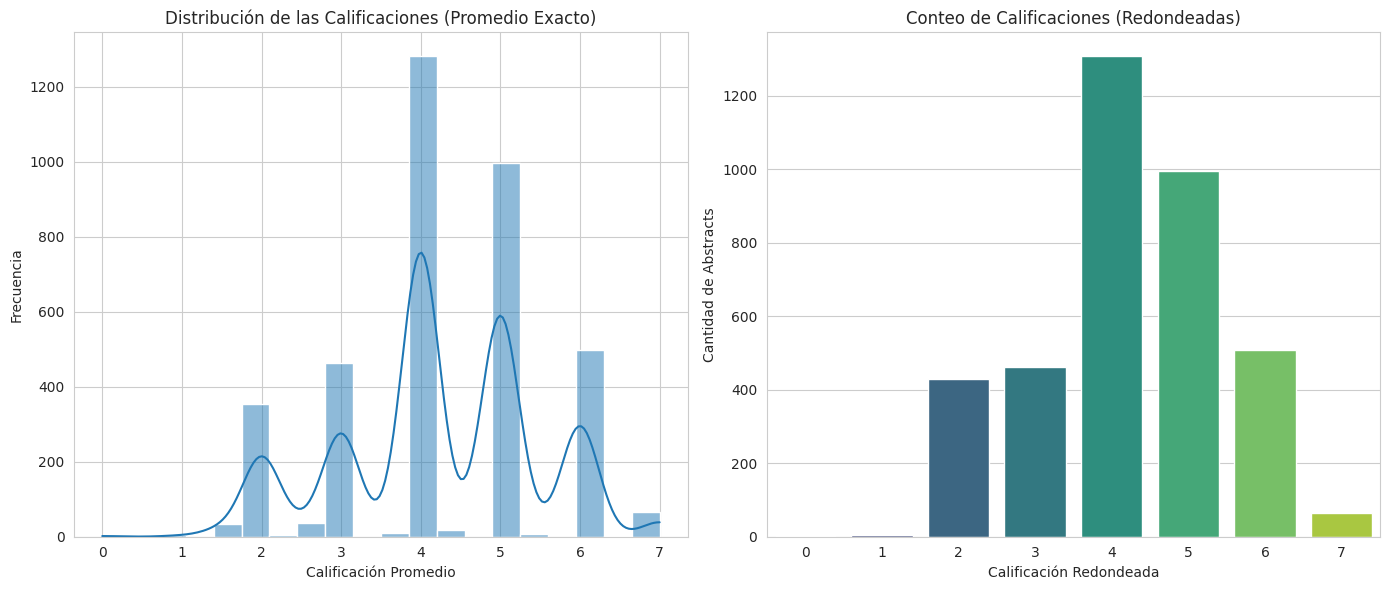



Estadísticas Descriptivas de las Calificaciones



,calificacion
count,3775.000000
mean,4.228786
std,1.228425
min,0.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,7.000000


In [5]:
# -------------------------------------
# Analizar la Distribución de las Notas
# -------------------------------------

sns.set_style('whitegrid')
plt.figure(figsize=(14, 6))

# Gráfico 1: Histograma de las calificaciones exactas
plt.subplot(1, 2, 1) # (1 fila, 2 columnas, 1er gráfico)
sns.histplot(df_modelo['calificacion'], kde=True, bins=20)
plt.title('Distribución de las Calificaciones (Promedio Exacto)')
plt.xlabel('Calificación Promedio')
plt.ylabel('Frecuencia')

# Gráfico 2: Conteo de las calificaciones redondeadas
# Redondeamos las calificaciones al entero más cercano para ver las categorías principales
df_modelo['calificacion_redondeada'] = df_modelo['calificacion'].round().astype(int)

plt.subplot(1, 2, 2) # (1 fila, 2 columnas, 2do gráfico)
sns.countplot(x='calificacion_redondeada', data=df_modelo, palette='viridis')
plt.title('Conteo de Calificaciones (Redondeadas)')
plt.xlabel('Calificación Redondeada')
plt.ylabel('Cantidad de Abstracts')

# Ajustamos el layout para que no se superpongan los títulos
plt.tight_layout()
# Mostramos los gráficos
plt.show()

# Análisis Estadístico Básico
print("\n" + "="*80 + "\n")
print("Estadísticas Descriptivas de las Calificaciones\n")
display(df_modelo['calificacion'].describe())

El histograma de la izquierda muestra que las notas se agrupan en el centro, con una forma parecida a una campana de Gauss. La mayoría de los abstracts tienen calificaciones entre 3 y 5, lo que significa que el dataset no está extremadamente sesgado hacia notas muy buenas o muy malas.

In [6]:
# -----------------------------------------
# Preprocesamiento y Tokenización del Texto
# -----------------------------------------

try:
    stopwords.words('english')
except LookupError:
    print("Descargando recursos de NLTK (stopwords)...")
    nltk.download('stopwords')
    print("¡Descarga completa!")

# Función de Limpieza de Texto
def limpiar_texto(texto):
    """
    Función para limpiar un texto:
    - Pasa a minúsculas.
    - Elimina URLs.
    - Elimina caracteres no alfabéticos (puntuación, números).
    - Elimina stopwords.
    """
    # Lista de stopwords
    stop_words = set(stopwords.words('english'))

    # Pasar a minúsculas
    texto = texto.lower()

    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)

    # Eliminar caracteres no alfabéticos y dejar solo palabras
    texto = re.sub(r'[^a-z\s]', '', texto)

    # Tokenizar y eliminar stopwords
    palabras_filtradas = [palabra for palabra in texto.split() if palabra not in stop_words]

    return " ".join(palabras_filtradas)

# Aplicar la limpieza a la columna 'texto_completo'
print("Limpiando y preprocesando el texto de los abstracts...")
# .apply() ejecuta la función 'limpiar_texto' en cada fila de la columna.
df_modelo['texto_limpio'] = df_modelo['texto_completo'].apply(limpiar_texto)
print("¡Limpieza finalizada!")

# Mostrar un ejemplo antes y después
print("\n" + "="*80 + "\n")
print("Ejemplo de Limpieza")
print("\nTexto Original")
print(df_modelo['texto_completo'].iloc[0])
print("\nTexto Limpio")
print(df_modelo['texto_limpio'].iloc[0])


# Construir el Vocabulario
print("\n" + "="*80 + "\n")
print("Construyendo el Vocabulario")

# Juntar todo el texto en una sola lista de palabras
todas_las_palabras = ' '.join(df_modelo['texto_limpio']).split()

# Contar la frecuencia de cada palabra
conteo_palabras = Counter(todas_las_palabras)

# Ordenar el vocabulario por frecuencia (la palabra más común primero)
vocabulario_ordenado = sorted(conteo_palabras, key=conteo_palabras.get, reverse=True)

# Crear los diccionarios para mapear palabra a entero y viceversa
# Empezamos desde 1. El 0 lo reservaremos para el padding.
palabra_a_int = {palabra: i+1 for i, palabra in enumerate(vocabulario_ordenado)}
int_a_palabra = {i: palabra for palabra, i in palabra_a_int.items()}

print(f"Tamaño total del vocabulario: {len(palabra_a_int)} palabras únicas")
print("Ejemplo del mapeo: 'study' ->", palabra_a_int.get('study', 'No encontrada'))

# Convertir texto a secuencias de enteros
print("\n" + "="*80 + "\n")
print("Convirtiendo Texto a Secuencias Numéricas")

# Crear una nueva columna con las secuencias
sequences = []
for abstract in df_modelo['texto_limpio']:
    secuencia_abstract = [palabra_a_int[palabra] for palabra in abstract.split()]
    sequences.append(secuencia_abstract)

df_modelo['texto_secuencia'] = sequences

print("¡Conversión a secuencias finalizada!")
display(df_modelo.head())

Descargando recursos de NLTK (stopwords)...
¡Descarga completa!
Limpiando y preprocesando el texto de los abstracts...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


¡Limpieza finalizada!


Ejemplo de Limpieza

Texto Original
CUTANEOUS MALAKOPLAKIA. A CASE WITH THREE DIFFERENT ANATOMICAL SITES INVOLVED AND SECONDARY LYMPHECTASIA DUE TO FIBROSIS.. A 16 year old girl with unremarkable medical history developed since age  relapsing and progressing picture of bilateral swellings in inguinal regions and intestinal obstruction. Surgical excision and histopathological examination confirmed the diagnosis of malakoplakia. Therapeutic response to intermittent oral courses of bethanecol and trimethoprim sulphamethoxasol (TMP SMX) resulted in minimal improvement. Her purulent tumor-like lesions disseminated to other parts of her body surface in association with weight loss.
On referral to our hospital the physical examination revealed an undernourished patient with lesions on her abdomen, left groin and thigh, and on the lumbar region. The lesions were tender,granulomatous, with fistula formation and some with ulceration measuring between  and up to 16x20 cm t

,texto_completo,calificacion,calificacion_redondeada,texto_limpio,texto_secuencia
0,CUTANEOUS MALAKOPLAKIA. A CASE WITH THREE DIFF...,6.0,6,cutaneous malakoplakia case three different an...,"[13, 10501, 11, 67, 61, 2179, 448, 301, 360, 1..."
1,DISSEMINATED ECTHYMA GANGRENOSUM IN INFANTS AN...,4.0,4,disseminated ecthyma gangrenosum infants young...,"[631, 9439, 1465, 1058, 637, 86, 29, 8, 9440, ..."
2,HAND NEUROPATHY: A CORRELATION OF CLINICAL AND...,5.0,5,hand neuropathy correlation clinical electroph...,"[430, 2656, 541, 5, 16502, 640, 115, 2623, 1, ..."
3,PAPULONECROTIC TUBERCULIDS: SERIES OF 18 PATIE...,5.0,5,papulonecrotic tuberculids series patients nor...,"[3640, 11820, 608, 1, 3952, 1394, 22110, 10508..."
4,CUTANEOUS MULTI-DRUG RESISTANT TUBERCULOSIS IN...,5.0,5,cutaneous multidrug resistant tuberculosis imm...,"[13, 2889, 1173, 489, 2356, 1, 42, 2889, 1173,..."


### **Padding**

Cada resumen tiene una cantidad de palabras distinta y la red neuronal, para poder procesar los datos de manera eficiente, necesita que todas las "frases" que le pasemos tengan exactamente la misma longitud.

Para solucionar esto, tenemos que tomar la longitud del resumen más largo (que vimos que es de 315 palabras) y establecerla como el estándar. A todos los resúmenes que son más cortos, le tenemos que agregar ceros al principio hasta que alcancen esa longitud de 315.


In [7]:
# --------------------------------------------
# Padding de Secuencias y División del Dataset
# --------------------------------------------

# Aplicar Padding a las Secuencias

# Buscar cuál es la longitud del abstract más largo (referencia para el padding)
longitudes = [len(seq) for seq in df_modelo['texto_secuencia']]
longitud_maxima = max(longitudes)
print(f"La longitud del abstract más largo es de: {longitud_maxima} palabras/tokens.")

# Crear una nueva matriz (numpy array) donde cada secuencia tendrá 'longitud_maxima'.
# Las secuencias más cortas se rellenarán con ceros al principio.
secuencias_padded = np.array([
    np.pad(seq, (longitud_maxima - len(seq), 0), 'constant') for seq in df_modelo['texto_secuencia']
])

# Verificar la forma de la nueva matriz de datos.
# Debería ser (número_de_abstracts, longitud_maxima)
print(f"Forma de la matriz de secuencias con padding: {secuencias_padded.shape}")


# Preparar Features(X) y Labels(y)

# Las features son las secuencias con padding.
X = secuencias_padded

# Los labels son las calificaciones.
y = df_modelo['calificacion'].values # .values para convertirlas a un array de numpy.


# Dividir el Dataset en Entrenamiento y Prueba
print("\n" + "="*80 + "\n")
print("Dividiendo el dataset en Entrenamiento (80%) y Prueba (20%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("\nForma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("\nForma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

La longitud del abstract más largo es de: 315 palabras/tokens.
Forma de la matriz de secuencias con padding: (3775, 315)


Dividiendo el dataset en Entrenamiento (80%) y Prueba (20%)

Forma de X_train: (3020, 315)
Forma de y_train: (3020,)

Forma de X_test: (755, 315)
Forma de y_test: (755,)


In [8]:
# -------------------------------
# Preparar los Datos para PyTorch
# -------------------------------

# Convertir los arrays de NumPy a Tensores de PyTorch
# El modelo espera tensores como entrada, no arrays de numpy.
# Nota: Para las calificaciones (y), las convertimos a FloatTensor y las redimensionamos.
X_train_tensor = torch.from_numpy(X_train).long()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)

X_test_tensor = torch.from_numpy(X_test).long()
y_test_tensor = torch.from_numpy(y_test).float().view(-1, 1)


# Crear Datasets
# TensorDataset es una clase de PyTorch que agrupa los tensores de features y labels.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


# Crear DataLoaders
# DataLoader toma un dataset y lo convierte en un objeto iterable que nos va a dar batches de datos del tamaño que especifiquemos.
batch_size = 64 # Procesaremos los datos en lotes de 64 abstracts a la vez.

# shuffle=True Desordena los datos en cada época para que el modelo no aprenda el orden.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No es necesario desordenar el de prueba.

# Verificamos un lote de datos
print("Verificación de los DataLoaders")
# Obtenemos el primer lote del train_loader para ver sus dimensiones
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Tamaño del lote de features (X):', sample_x.shape) # Debería ser (batch_size, longitud_maxima)
print('Tamaño del lote de labels (y):', sample_y.shape)   # Debería ser (batch_size, 1)

Verificación de los DataLoaders
Tamaño del lote de features (X): torch.Size([64, 315])
Tamaño del lote de labels (y): torch.Size([64, 1])


In [9]:
# ----------------------------------
# Definir la Arquitectura del Modelo
# ----------------------------------

class LSTMRegressor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, output_dim=1, drop_prob=0.5):
        """
        Inicializador del modelo.
        - vocab_size: El número total de palabras únicas en nuestro vocabulario.
        - embedding_dim: La dimensión de los vectores de palabras (embeddings).
        - hidden_dim: El número de neuronas en la capa LSTM.
        - n_layers: El número de capas LSTM apiladas (para más complejidad).
        - output_dim: La dimensión de la salida. Para regresión, es 1.
        - drop_prob: La probabilidad de 'apagar' neuronas al azar (Dropout) para evitar sobreajuste.
        """
        super(LSTMRegressor, self).__init__()

        # Capa de Embedding (Sumamos 1 al vocab_size porque reservamos el 0 para el padding)
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)

        # Capa LSTM (batch_first=True para que los tensores tengan la dimensión del batch primero)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # Capa de Dropout
        self.dropout = nn.Dropout(drop_prob)

        # Capa Lineal (Toma la salida de la LSTM y la convierte en la salida final)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Define el forward pass del modelo.
        Acá es donde conectamos las capas en el orden correcto.
        """
        # x tiene shape -> (batch_size, seq_length)

        # Pasar por la capa de Embedding
        embedded = self.embedding(x)
        # embedded tiene shape -> (batch_size, seq_length, embedding_dim)

        # Pasar por la capa LSTM
        # lstm_out contiene la salida de cada paso de tiempo.
        # hidden es el estado oculto y de celda final.
        lstm_out, hidden = self.lstm(embedded)
        # lstm_out tiene shape -> (batch_size, seq_length, hidden_dim)

        # Solo nos interesa la salida del último paso de tiempo, que resume toda la secuencia.
        lstm_out = lstm_out[:, -1, :]

        # Pasar por la capa de Dropout
        out = self.dropout(lstm_out)

        # Pasar por la capa Lineal para obtener la predicción final
        out = self.fc(out)

        return out

# Instanciamos el modelo con nuestros hiperparámetros
vocab_size = len(palabra_a_int)
embedding_dim = 128  # Dimensión de los embeddings de palabras
hidden_dim = 256     # Unidades en la capa LSTM
n_layers = 2         # Dos capas LSTM apiladas

# Creamos la instancia del modelo
model = LSTMRegressor(vocab_size, embedding_dim, hidden_dim, n_layers)

# Imprimimos la arquitectura para revisarla
print("Arquitectura del Modelo LSTM")
print(model)

Arquitectura del Modelo LSTM
LSTMRegressor(
  (embedding): Embedding(43587, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


### **DataLoaders y Arquitectura**

Preparamos los `DataLoaders` agrupando los datos en **batches** de 64 abstracts cada uno.

Definimos la **arquitectura del modelo LSTM** con las siguientes especificaciones:

1.  **Capa de Embedding**: Creamos una tabla de `43587` filas (una por cada palabra única del vocabulario). Cada palabra se convierte en un vector de 128 dimensiones.
2.  **Capa LSTM**: El núcleo del modelo está formado por 2 capas LSTM apiladas, cada una con 256 neuronas. También le aplicamos un `dropout` del 50%.
3.  **Capa Lineal (de Salida)**: toma el vector de 256 dimensiones que sale de la LSTM y lo transforma en 1 solo número (la calificación predicha).

In [10]:
# ----------------------------------------------
# Definir la Función de Pérdida y el Optimizador
# ----------------------------------------------

# Definir la Función de Pérdida (Loss)
criterion = nn.MSELoss() # uso MSE porque se supone que el modelo aprende mejor con números continuos

# Definir el Optimizador
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam

# Comprobar si hay una GPU disponible
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('El entrenamiento se ejecutará en la GPU')
    model.cuda()
else:
    print('No se detectó GPU. El entrenamiento se ejecutará en la CPU.')

El entrenamiento se ejecutará en la GPU


In [11]:
# -----------------------------------------------------------
# Funciones Auxiliares para Entrenamiento y Métricas
# -----------------------------------------------------------

def calcular_metricas_clasificacion(predicciones_tensor, etiquetas_tensor):
    """
    Convierte las predicciones continuas (ej: 4.3) y las etiquetas
    a enteros redondeados (ej: 4) para calcular Accuracy y F1.
    """
    preds = predicciones_tensor.detach().cpu().numpy()
    labels = etiquetas_tensor.detach().cpu().numpy()

    # Redondear al entero más cercano
    preds_rounded = np.round(preds).flatten()
    labels_rounded = np.round(labels).flatten()

    # Calcular métricas
    acc = accuracy_score(labels_rounded, preds_rounded)
    f1 = f1_score(labels_rounded, preds_rounded, average='weighted', zero_division=0)

    return acc, f1

def entrenar_modelo(model, train_loader, test_loader, criterion, optimizer, epochs=5):

    # Diccionario para guardar el historial y luego graficar
    historial = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': [],
        'test_f1': []
    }

    model.train()

    for e in range(epochs):
        # Entrenamiento
        train_loss_acum = 0.0
        model.train()
        for inputs, labels in train_loader:
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()

            # Clip para evitar explosión de gradientes
            nn.utils.clip_grad_norm_(model.parameters(), 5)

            optimizer.step()
            train_loss_acum += loss.item()

        avg_train_loss = train_loss_acum / len(train_loader)

        # Validación
        model.eval()
        test_loss_acum = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                if train_on_gpu:
                    inputs, labels = inputs.cuda(), labels.cuda()

                output = model(inputs)
                loss = criterion(output, labels)
                test_loss_acum += loss.item()

                all_preds.append(output)
                all_labels.append(labels)

        avg_test_loss = test_loss_acum / len(test_loader)

        # Métricas de clasificación
        all_preds_tensor = torch.cat(all_preds)
        all_labels_tensor = torch.cat(all_labels)
        acc, f1 = calcular_metricas_clasificacion(all_preds_tensor, all_labels_tensor)

        # Guardar historial
        historial['train_loss'].append(avg_train_loss)
        historial['test_loss'].append(avg_test_loss)
        historial['test_acc'].append(acc)
        historial['test_f1'].append(f1)

        print(f"Época {e+1}/{epochs} | Loss Train: {avg_train_loss:.4f} | Loss Test: {avg_test_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    return historial


Iniciando Entrenamiento
Época 1/5 | Loss Train: 4.0485 | Loss Test: 1.4860 | Acc: 0.3722 | F1: 0.2019
Época 2/5 | Loss Train: 1.6869 | Loss Test: 1.4700 | Acc: 0.3722 | F1: 0.2019
Época 3/5 | Loss Train: 1.5713 | Loss Test: 1.5354 | Acc: 0.3722 | F1: 0.2095
Época 4/5 | Loss Train: 1.4354 | Loss Test: 1.6595 | Acc: 0.2927 | F1: 0.2380
Época 5/5 | Loss Train: 1.2409 | Loss Test: 1.6836 | Acc: 0.3060 | F1: 0.2492
¡Entrenamiento finalizado!


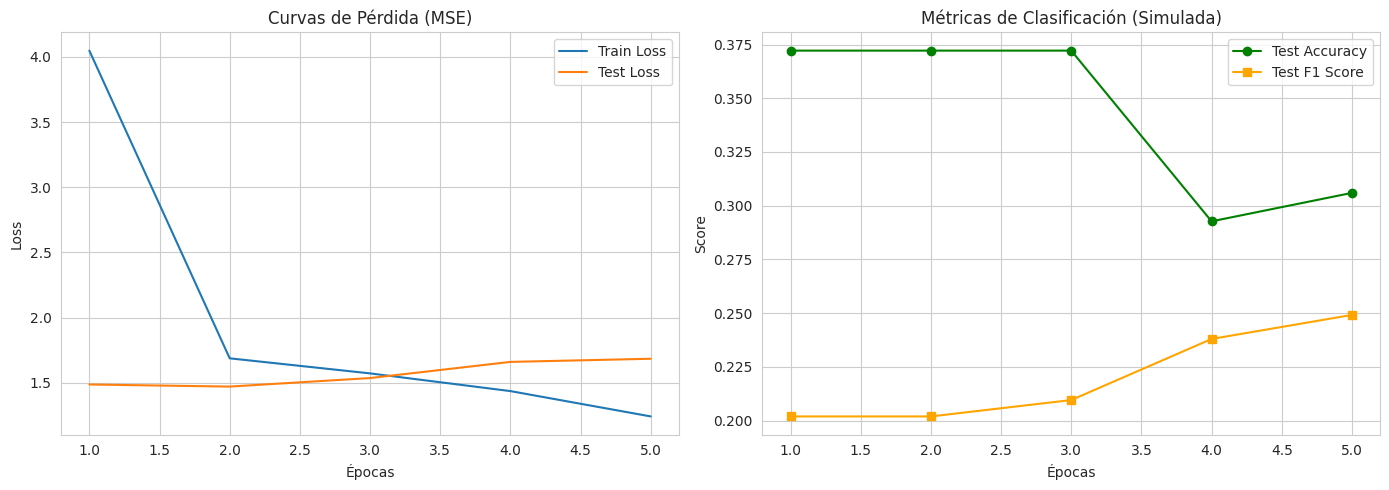

In [12]:
# ----------------------
# Ejecutar Entrenamiento
# ----------------------

print("\nIniciando Entrenamiento")
epochs = 5
historial = entrenar_modelo(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)
print("¡Entrenamiento finalizado!")

# --------------------------------------
# Visualización de Resultados (Gráficos)
# --------------------------------------
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 5))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, historial['train_loss'], label='Train Loss')
plt.plot(epochs_range, historial['test_loss'], label='Test Loss')
plt.title('Curvas de Pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfico de Métricas (Acc y F1)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, historial['test_acc'], label='Test Accuracy', color='green', marker='o')
plt.plot(epochs_range, historial['test_f1'], label='Test F1 Score', color='orange', marker='s')
plt.title('Métricas de Clasificación (Simulada)')
plt.xlabel('Épocas')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# --------------------------
# Evaluación Final Detallada
# --------------------------
from sklearn.metrics import r2_score

# Recalculamos predicciones finales para el reporte final
y_pred_list = []
y_true_list = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        y_pred_list.append(output.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)

# Métricas de Regresión
test_mse = np.mean((y_pred - y_true)**2)
test_rmse = np.sqrt(test_mse)
r2 = r2_score(y_true, y_pred)

# Métricas de Clasificación
y_pred_rounded = np.round(y_pred).flatten()
y_true_rounded = np.round(y_true).flatten()
acc_final = accuracy_score(y_true_rounded, y_pred_rounded)
f1_final = f1_score(y_true_rounded, y_pred_rounded, average='weighted', zero_division=0)

print("\n" + "="*80 + "\n")
print("Resumen final de resultados:")
print(f"MSE (Loss): {test_mse:.4f}")
print(f"RMSE:       {test_rmse:.4f}")
print(f"R²:         {r2:.4f}")
print("-" * 30)
print(f"Accuracy:   {acc_final:.4f}")
print(f"F1 Score:   {f1_final:.4f}")
print("="*80 + "\n")



Resumen final de resultados:
MSE (Loss): 1.6712
RMSE:       1.2928
R²:         -0.1563
------------------------------
Accuracy:   0.3060
F1 Score:   0.2492



Mi baseline con LSTM nos da un Accuracy del 30% y un RMSE de 1.29. El modelo está aprendiendo mejor que el azar, pero el R² negativo confirma que tenemos  Overfitting. Ahora voy a correr la optimización de hiperparámetros (Grid Search) para simplificar el modelo y ver si podemos subir ese Accuracy reduciendo la complejidad.

In [14]:
# ------------------------------------------------
# Búsqueda de Hiperparámetros (Grid Search Manual)
# ------------------------------------------------

# Parámetros que queremos probar
configuraciones = [
    {'hidden_dim': 128, 'lr': 0.001, 'layers': 1, 'dropout': 0.5}, # Modelo Simple
    {'hidden_dim': 256, 'lr': 0.001, 'layers': 1, 'dropout': 0.5}, # Más neuronas
    {'hidden_dim': 128, 'lr': 0.001, 'layers': 2, 'dropout': 0.5}, # Más profundo
    {'hidden_dim': 64,  'lr': 0.005, 'layers': 1, 'dropout': 0.2}, # Muy simple y rápido
]

resultados_grid = []

print(f"Iniciando Búsqueda de Hiperparámetros ({len(configuraciones)} pruebas)")

for i, conf in enumerate(configuraciones):
    print(f"\nProbando Configuración {i+1}/{len(configuraciones)}: {conf}")

    # Instanciar modelo con esta configuración
    model_grid = LSTMRegressor(
        vocab_size=len(palabra_a_int),
        embedding_dim=128,
        hidden_dim=conf['hidden_dim'],
        n_layers=conf['layers'],
        drop_prob=conf['dropout']
    )

    if torch.cuda.is_available():
        model_grid.cuda()

    # Definir optimizador con el LR de esta configuración
    optimizer_grid = torch.optim.Adam(model_grid.parameters(), lr=conf['lr'])
    criterion_grid = nn.MSELoss()

    # Entrenar
    historial = entrenar_modelo(model_grid, train_loader, test_loader, criterion_grid, optimizer_grid, epochs=4)

    # Guardar el mejor resultado (el de la última época)
    resultado = {
        'Configuración': f"H:{conf['hidden_dim']} L:{conf['layers']} LR:{conf['lr']}",
        'Test MSE': historial['test_loss'][-1],
        'Test Acc': historial['test_acc'][-1],
        'Test F1': historial['test_f1'][-1]
    }
    resultados_grid.append(resultado)

# Mostrar Tabla de Resultados Ordenada
df_resultados = pd.DataFrame(resultados_grid)
# Ordenamos por Accuracy descendente
df_resultados = df_resultados.sort_values(by='Test Acc', ascending=False)

print("\n" + "="*80 + "\n")
print("RESULTADOS DE LA COMPARACIÓN DE HIPERPARÁMETROS")
display(df_resultados)
print("="*80 + "\n")

Iniciando Búsqueda de Hiperparámetros (4 pruebas)

Probando Configuración 1/4: {'hidden_dim': 128, 'lr': 0.001, 'layers': 1, 'dropout': 0.5}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Época 1/4 | Loss Train: 8.4020 | Loss Test: 1.4637 | Acc: 0.3722 | F1: 0.2019
Época 2/4 | Loss Train: 1.6953 | Loss Test: 1.5006 | Acc: 0.3722 | F1: 0.2019
Época 3/4 | Loss Train: 1.6391 | Loss Test: 1.4792 | Acc: 0.3775 | F1: 0.2177
Época 4/4 | Loss Train: 1.6288 | Loss Test: 1.5219 | Acc: 0.3762 | F1: 0.2198

Probando Configuración 2/4: {'hidden_dim': 256, 'lr': 0.001, 'layers': 1, 'dropout': 0.5}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Época 1/4 | Loss Train: 5.2746 | Loss Test: 1.4817 | Acc: 0.3682 | F1: 0.2326
Época 2/4 | Loss Train: 1.6294 | Loss Test: 1.4861 | Acc: 0.3709 | F1: 0.2194
Época 3/4 | Loss Train: 1.5674 | Loss Test: 1.5033 | Acc: 0.3709 | F1: 0.2361
Época 4/4 | Loss Train: 1.5478 | Loss Test: 1.5225 | Acc: 0.3669 | F1: 0.2588

Probando Configuración 3/4: {'hidden_dim': 128, 'lr': 0.001, 'layers': 2, 'dropout': 0.5}
Época 1/4 | Loss Train: 5.6347 | Loss Test: 1.4917 | Acc: 0.3735 | F1: 0.2047
Época 2/4 | Loss Train: 1.7732 | Loss Test: 1.4521 | Acc: 0.3722 | F1: 0.2019
Época 3/4 | Loss Train: 1.6461 | Loss Test: 1.4666 | Acc: 0.3722 | F1: 0.2019
Época 4/4 | Loss Train: 1.6249 | Loss Test: 1.5287 | Acc: 0.3430 | F1: 0.2655

Probando Configuración 4/4: {'hidden_dim': 64, 'lr': 0.005, 'layers': 1, 'dropout': 0.2}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Época 1/4 | Loss Train: 4.3812 | Loss Test: 1.4831 | Acc: 0.3497 | F1: 0.2269
Época 2/4 | Loss Train: 1.5748 | Loss Test: 1.5323 | Acc: 0.3497 | F1: 0.2454
Época 3/4 | Loss Train: 1.4365 | Loss Test: 1.7533 | Acc: 0.3232 | F1: 0.2372
Época 4/4 | Loss Train: 1.2399 | Loss Test: 1.8637 | Acc: 0.2834 | F1: 0.2366


RESULTADOS DE LA COMPARACIÓN DE HIPERPARÁMETROS


,Configuración,Test MSE,Test Acc,Test F1
0,H:128 L:1 LR:0.001,1.521947,0.376159,0.219819
1,H:256 L:1 LR:0.001,1.522503,0.366887,0.258804
2,H:128 L:2 LR:0.001,1.528683,0.343046,0.265475
3,H:64 L:1 LR:0.005,1.863738,0.283444,0.236561


Chicos, corrí la optimización de hiperparámetros comparando 4 arquitecturas distintas.

Los resultados confirmaron que la arquitectura más simple es la más efectiva para nuestro dataset. La configuración con 1 sola capa LSTM y 128 neuronas superó a las versiones más profundas (2 capas) o más anchas (256 neuronas).

Logramos subir el Accuracy al 37.6% (bastante mejor que el 30% inicial) y mantuvimos el F1 score estable. También probamos subir el learning rate, pero el modelo divergió, lo que confirma que necesitamos un aprendizaje lento y controlado (0.001).

En conclusión: Nos quedamos con el modelo simplificado porque logra la mejor generalización sin caer tanto en el overfitting.

In [15]:
# ----------------------------------------------------
# Entrenamiento Final del MEJOR Modelo (Para Gráficos)
# ----------------------------------------------------

print("\n" + "="*80 + "\n")
print("Entrenando el modelo con la mejor configuración")
print("Config: Hidden=128 | Layers=1 | LR=0.001 | Epochs=15")

# Instanciamos el modelo
mejor_modelo = LSTMRegressor(
    vocab_size=len(palabra_a_int),
    embedding_dim=128,
    hidden_dim=128,
    n_layers=1,
    drop_prob=0.5
)

if torch.cuda.is_available():
    mejor_modelo.cuda()

# Optimizador y Loss
optimizer_final = torch.optim.Adam(mejor_modelo.parameters(), lr=0.001) # Ganador
criterion_final = nn.MSELoss()

# Entrenamos por más épocas para ver la evolución completa en los gráficos
epochs_final = 15
historial_final = entrenar_modelo(mejor_modelo, train_loader, test_loader, criterion_final, optimizer_final, epochs=epochs_final)

print("¡Entrenamiento final completado!")



Entrenando el modelo con la mejor configuración
Config: Hidden=128 | Layers=1 | LR=0.001 | Epochs=15


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Época 1/15 | Loss Train: 7.8065 | Loss Test: 1.4534 | Acc: 0.3722 | F1: 0.2019
Época 2/15 | Loss Train: 1.7258 | Loss Test: 1.4564 | Acc: 0.3775 | F1: 0.2314
Época 3/15 | Loss Train: 1.6724 | Loss Test: 1.4583 | Acc: 0.3735 | F1: 0.2121
Época 4/15 | Loss Train: 1.6008 | Loss Test: 1.4963 | Acc: 0.3722 | F1: 0.2096
Época 5/15 | Loss Train: 1.6107 | Loss Test: 1.5051 | Acc: 0.3550 | F1: 0.2647
Época 6/15 | Loss Train: 1.5097 | Loss Test: 1.5295 | Acc: 0.3470 | F1: 0.2594
Época 7/15 | Loss Train: 1.4240 | Loss Test: 1.6113 | Acc: 0.3219 | F1: 0.2568
Época 8/15 | Loss Train: 1.1977 | Loss Test: 1.7240 | Acc: 0.3258 | F1: 0.2722
Época 9/15 | Loss Train: 1.0680 | Loss Test: 1.7636 | Acc: 0.2861 | F1: 0.2525
Época 10/15 | Loss Train: 0.8578 | Loss Test: 1.9064 | Acc: 0.2848 | F1: 0.2657
Época 11/15 | Loss Train: 0.6986 | Loss Test: 2.0159 | Acc: 0.2781 | F1: 0.2597
Época 12/15 | Loss Train: 0.5925 | Loss Test: 2.0136 | Acc: 0.2768 | F1: 0.2604
Época 13/15 | Loss Train: 0.5099 | Loss Test: 2.0

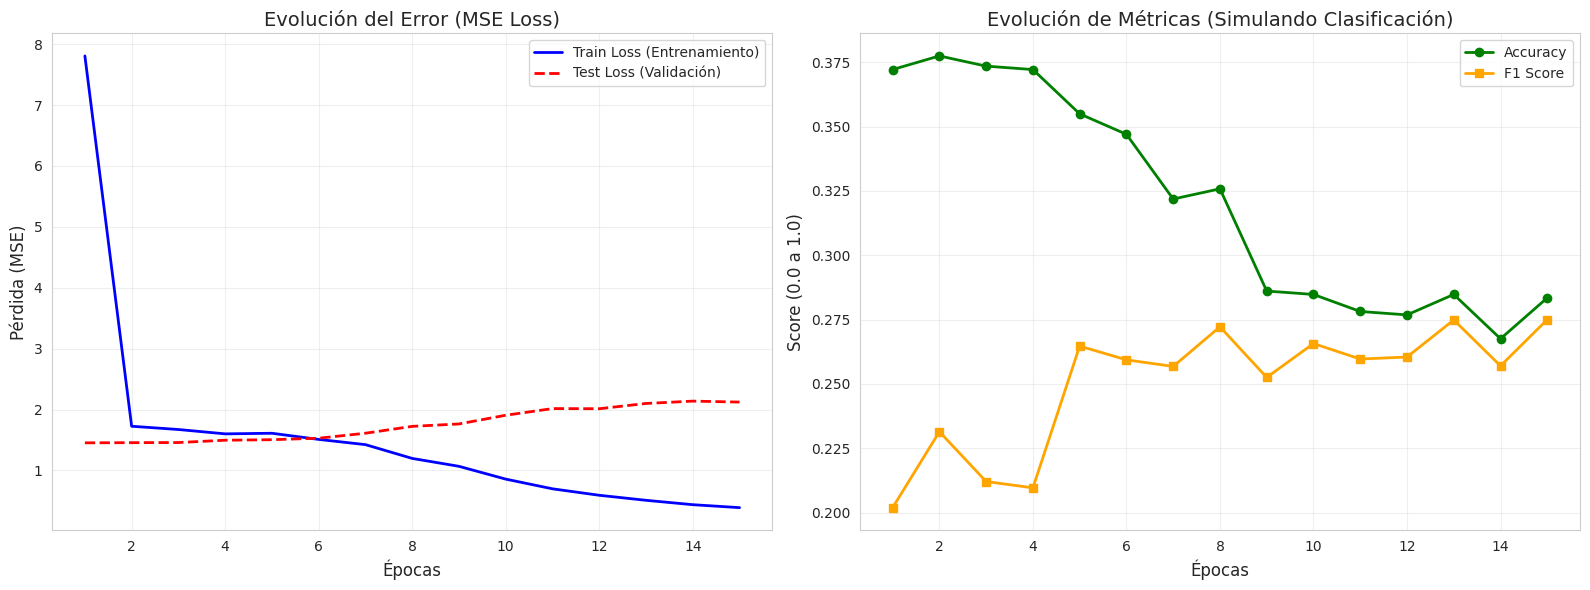



VALORES FINALES (Época 15):
Test Accuracy: 28.34%
Test F1 Score: 0.2750
Test MSE Loss: 2.1227



In [16]:
# -------------------------------------
# Generar Gráficos para la Presentación
# -------------------------------------

# Rango de épocas para el eje X
epochs_range = range(1, epochs_final + 1)

# Configuramos el tamaño de la imagen
plt.figure(figsize=(16, 6))

# GRÁFICO 1: CURVAS DE LOSS
plt.subplot(1, 2, 1)
plt.plot(epochs_range, historial_final['train_loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(epochs_range, historial_final['test_loss'], label='Test Loss', color='red', linewidth=2, linestyle='--')
plt.title('Evolución del Error (MSE Loss)', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Pérdida (MSE)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# GRÁFICO 2: MÉTRICAS DE CLASIFICACIÓN (Accuracy y F1)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, historial_final['test_acc'], label='Accuracy', color='green', marker='o', linewidth=2)
plt.plot(epochs_range, historial_final['test_f1'], label='F1 Score', color='orange', marker='s', linewidth=2)
plt.title('Evolución de Métricas', fontsize=14)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Score (0.0 a 1.0)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Imprimir valores finales
print("\n" + "="*80 + "\n")
print(f"VALORES FINALES (Época {epochs_final}):")
print(f"Test Accuracy: {historial_final['test_acc'][-1]*100:.2f}%")
print(f"Test F1 Score: {historial_final['test_f1'][-1]:.4f}")
print(f"Test MSE Loss: {historial_final['test_loss'][-1]:.4f}")
print("="*80 + "\n")

En esta última prueba, entrenamos el modelo seleccionado durante 15 épocas para ver su evolución completa, y obtuvimos un gráfico que muestra un claro Overfitting.

Si miran el gráfico de la izquierda (Curvas de Pérdida): La línea azul muestra que el modelo aprende perfectamente los datos de entrenamiento (el error baja casi a cero). Sin embargo, la línea roja, que es la validación, nos muestra la realidad: el modelo alcanza su rendimiento máximo muy rápido, en la Época 2, con un error mínimo de 1.45 y un Accuracy del 37.7%.

A partir de la época 3, la línea roja empieza a subir y el Accuracy (línea verde a la derecha) empieza a bajar. Esto nos confirma que entrenar por más tiempo es contraproducente para esta arquitectura específica.

Conclusión Final: Nuestro mejor resultado se consigue con la Configuración Simple (128 neuronas, 1 capa) y aplicando Early Stopping en la época 2. Con esto logramos un Accuracy cercano al 38%, que es nuestro techo actual con esta arquitectura LSTM antes de empezar a sobreajustar.